In [7]:
# Importation des libraries/packages de base. 

import pandas as pd
import os
import numpy as np
import dask.dataframe as dd 
import warnings 
warnings.filterwarnings("ignore")



In [44]:
# Fichier avec les variables d'intéret : dernière version : 21/02 

df_cct = pd.read_parquet("/Users/vanheuverswyn/Desktop/ProjetStatapp/df_cct_final.parquet")

In [25]:
# Visualisation du fichier : 

df_cct.head()

User  Card  Year  Month  Day  Hours  Amount           Use Chip Card Brand  \
0     0     0  2002      9    1      6  134.09  Swipe Transaction       Visa   
1     0     0  2002      9    1      6   38.48  Swipe Transaction       Visa   
2     0     0  2002      9    2      6  120.34  Swipe Transaction       Visa   
3     0     0  2002      9    2     17  128.95  Swipe Transaction       Visa   
4     0     0  2002      9    3      6  104.71  Swipe Transaction       Visa   

  Card Type  ...  daily_amount  nb_daily_declines_card  \
0     Debit  ...        134.09                     0.0   
1     Debit  ...        172.57                     0.0   
2     Debit  ...        120.34                     0.0   
3     Debit  ...        249.29                     0.0   
4     Debit  ...        104.71                     0.0   

  nb_weekly_declines_card nb_monthly_declines_card  bad_pin  \
0                     0.0                      0.0        0   
1                     0.0                      0.0        0   
2                     0.0                      0.0        0   
3                     0.0                      0.0        0   
4                     0.0                      0.0        0   

   insufficient_balance hr_nbt/last_30d_av_hr_nbt  \
0                     0                  1.000000   
1                     0                  1.333333   
2                     0                  0.750000   
3                     0                  0.800000   
4                     0                  0.833333   

   day_nbt/last_30d_av_day_nbt  last_3d_amt/nbt  Is Fraud?  
0                     1.000000       134.090000          0  
1                     1.333333        86.285000          0  
2                     1.200000        97.636667          0  
3                     1.142857       105.465000          0  
4                     1.111111       105.314000          0  

[5 rows x 29 columns]

In [26]:
# Nom des colonnes : 

df_cct.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Hours', 'Amount', 'Use Chip',
       'Card Brand', 'Card Type', 'Credit Limit', 'Year PIN last Changed',
       'Merchant City', 'Merchant State', 'delta_t_s', 'delta_t_s_card',
       'day_of_week', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_weekly_declines_card',
       'nb_monthly_declines_card', 'bad_pin', 'insufficient_balance',
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt', 'Is Fraud?'],
      dtype='object')

In [7]:
# Gérer les variables catégorielles pour DBSCAN. 
# Eviter le problème de hiérarchie entre les modalités : 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?fbclid=IwAR2eCoPI9skUHDegZeP31K--Psh2thHY_5anQPtngWD6qU3caG1UxFdwtR4
# On utilise One Encoder. 
# Package sklearn.preprocessing. 
# On recode sous forme de dummies les modalités intéressantes. 

#=> Pour le rapport final : expliquer les maths derrière DBSCAN, ACP, UMAP, One Encoder... 
#=> Expliquer comment ça marche théoriquement.

In [59]:
# On a plus besoin de ces variables catégorielles, on les a retraité: "Merchant State", "Merchant City", "Use Chip"

# On retire également la variable "Card" et "User" : pas d'intérêt pour le clustering. 
# On souhaite étudier les types de transaction de manière générale. 
#On retire egalement les données temporelles (sauf l’année dont on a encore besoin) et les jours de la semaines qui n'ont pas donne d'information intéressantes

df_cct =  df_cct.drop(["Merchant State", "Merchant City", "Use Chip", 'day_of_week','Card','User', 'Month', 'Day', 'Hours'], axis = 1)




KeyError: "['Merchant State', 'Merchant City', 'Use Chip', 'day_of_week', 'Card', 'User', 'Month', 'Day', 'Hours'] not found in axis"

In [13]:
# On ne centre réduit pas toutes les variables (perte d'information), on centre réduit unquement "timesstamp". 

#for i in range(len(df_cct.columns)):
    #mean = np.mean(df_cct[df_cct.columns[i]])
    #ec = np.std(df_cct[df_cct.columns[i]])
    #df_cct[df_cct.columns[i]] = (df_cct[df_cct.columns[i]]-mean)/ec

#mean = np.mean(df_cct[df_cct.columns["timestamp"]])
#ec = np.std(df_cct[df_cct.columns["timestamp"]])
#df_cct[df_cct.columns["timestamp"]] = (df_cct[df_cct.columns["timestamp"]]-mean)/ec


# Ici, on a pas besoin de centrer réduire les variables : 

# df_cct.head()

In [46]:
# Nom des colonnes : 

df_cct.columns

Index(['Year', 'Amount', 'Card Brand', 'Card Type', 'Credit Limit',
       'Year PIN last Changed', 'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'Retired', 'daily_amount', 'nb_daily_declines_card',
       'nb_weekly_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Is Fraud?'],
      dtype='object')

In [29]:
# Importation des libraries pour l'ACP et DBSCAN. 

import pandas.util.testing as tm
import seaborn as sns
from sklearn import cluster 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from collections import Counter

In [47]:
# Problème de puissance de calcul on fait DBSCAN seulement sur 200 000 transactions tirées aléatoirement. 
# Sinon le Kernel meurt.... 
# Important : Nouvelle idée : => surreprésenter les frauds pour pouvoir interpréter quelque chose. 
# On va prendre 5 % de fraud : 10000 sur l'échantillon de 200000.
# On selectionne aléatoirement les frauds et non frauds et on mélanger l'échnatillon. 
#
#df_cct = df_cct1
df_cct1 = df_cct.copy()

# Fraud : 
df_cct_fraud = df_cct[df_cct['Is Fraud?'] == 1 ]
df_cct_non_fraud = df_cct[df_cct['Is Fraud?'] == 0 ]

#len(df_cct_fraud)
ech1 = df_cct_fraud.sample(10000)
ech2 = df_cct_non_fraud.sample(190000)

df_cct =  pd.concat([ech1, ech2], axis = 0)
df_cct = df_cct.sample(200000)


df_cct2 = df_cct.copy()


In [41]:
df_cct=df_cct2.copy()

In [48]:
#on crée des dummies pour traiter les valeurs que prennent les variables 'Card Brand' et 'Card Type'

from sklearn import preprocessing

#la selection aleatoire de valeur dans le dataset engendrent des decalages d'index, 
#pour ne pas avoir de soucis lors de la concatenations des dataframe (df_cct et dummies), on reinitialise les index
df_cct=df_cct.reset_index()    
df_cct =  df_cct.drop(["index"], axis = 1)

enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
features_array = enc.fit_transform(df_cct[['Card Brand']]).toarray()
features_labels = np.hstack(np.array(enc.categories_))
df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels).reset_index()], axis = 1)

enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
features_array = enc.fit_transform(df_cct[['Card Type']]).toarray()
features_labels = np.hstack(np.array(enc.categories_))
df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

df_cct =  df_cct.drop(["index","Card Brand",'Card Type'], axis = 1)


In [49]:
df_cct

Year  Amount  Credit Limit  Year PIN last Changed  delta_t_s  \
0       2015    1.22       23404.0                   2012       3600   
1       2015   74.00       12700.0                   2009      74580   
2       2001   12.50       14269.0                   2011      25080   
3       2013    2.64       13863.0                   2014      14220   
4       2019  -79.00       27268.0                   2012        420   
...      ...     ...           ...                    ...        ...   
199995  2005    3.01       17432.0                   2014      44940   
199996  2017  120.00        3400.0                   2008      87300   
199997  2006    8.02       37634.0                   2006        540   
199998  2009    1.27       14561.0                   2015       1440   
199999  2020    4.48       20479.0                   2008       1800   

        delta_t_s_card  amt/daily_income  Retired  daily_amount  \
0                23880          0.006980        0         86.99   
1                74580          0.577593        0         74.00   
2                25080          0.138902        0         18.37   
3                14220          0.024368        0          9.46   
4                  420         -0.538429        0        498.90   
...                ...               ...      ...           ...   
199995           44940          0.018330        1          3.01   
199996           87300          1.571921        1        120.00   
199997             540          0.054870        0        157.91   
199998            1440          0.012833        0         46.86   
199999            1800          0.034774        0        211.16   

        nb_daily_declines_card  ...  day_nbt/last_30d_av_day_nbt  \
0                          0.0  ...                     1.206107   
1                          0.0  ...                     1.243243   
2                          0.0  ...                     0.453333   
3                          0.0  ...                     1.118421   
4                          0.0  ...                     1.543897   
...                        ...  ...                          ...   
199995                     0.0  ...                     0.946136   
199996                     0.0  ...                     0.431818   
199997                     1.0  ...                     1.405152   
199998                     0.0  ...                     1.031250   
199999                     0.0  ...                     1.488608   

        last_3d_amt/nbt  Is Fraud?  Amex  Discover  Mastercard  Visa  Credit  \
0             53.877500          0   0.0       0.0         0.0   1.0     0.0   
1             59.850000          0   0.0       1.0         0.0   0.0     1.0   
2             62.719231          0   0.0       0.0         1.0   0.0     0.0   
3             13.556000          0   0.0       0.0         1.0   0.0     0.0   
4             72.870909          0   0.0       0.0         1.0   0.0     0.0   
...                 ...        ...   ...       ...         ...   ...     ...   
199995        99.811250          0   0.0       0.0         1.0   0.0     0.0   
199996       100.000000          0   0.0       0.0         1.0   0.0     1.0   
199997        45.788000          0   0.0       0.0         1.0   0.0     0.0   
199998        41.405000          0   0.0       0.0         1.0   0.0     0.0   
199999        37.274444          0   0.0       0.0         1.0   0.0     0.0   

        Debit  Debit (Prepaid)  
0         1.0              0.0  
1         0.0              0.0  
2         1.0              0.0  
3         1.0              0.0  
4         1.0              0.0  
...       ...              ...  
199995    1.0              0.0  
199996    0.0              0.0  
199997    1.0              0.0  
199998    1.0              0.0  
199999    1.0              0.0  

[200000 rows x 25 columns]

In [50]:
df_cct.columns

Index(['Year', 'Amount', 'Credit Limit', 'Year PIN last Changed', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_weekly_declines_card',
       'nb_monthly_declines_card', 'bad_pin', 'insufficient_balance',
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt', 'Is Fraud?', 'Amex', 'Discover', 'Mastercard',
       'Visa', 'Credit', 'Debit', 'Debit (Prepaid)'],
      dtype='object')

In [51]:
#Il est plus judicieux de remplacer la variable "Year PIN last Changed" par Number_year_since_PIN_last_Changed
df_cct["Number_year_since_PIN_last_Changed"]=df_cct["Year PIN last Changed"]-df_cct["Year"]
df_cct =  df_cct.drop(["Year","Year PIN last Changed"], axis = 1)


In [52]:
print(df_cct.describe())

              Amount   Credit Limit     delta_t_s  delta_t_s_card  \
count  200000.000000  200000.000000  2.000000e+05    2.000000e+05   
mean       46.754110   15160.624675  2.903291e+04    6.632195e+04   
std        91.595627   12116.528706  3.076797e+05    1.185037e+06   
min      -500.000000       0.000000  0.000000e+00    0.000000e+00   
25%         9.410000    7600.000000  2.640000e+03    5.160000e+03   
50%        31.270000   13200.000000  1.314000e+04    2.898000e+04   
75%        68.110000   20289.000000  4.242000e+04    8.094000e+04   
max      3603.990000  151223.000000  1.342663e+08    4.261833e+08   

       amt/daily_income        Retired   daily_amount  nb_daily_declines_card  \
count     200000.000000  200000.000000  200000.000000           200000.000000   
mean           8.976556       0.224585     129.973539                0.043690   
std          636.046032       0.417310     185.700518                0.223699   
min       -75920.000000       0.000000       0.000000 

In [53]:
df_cct.columns

Index(['Amount', 'Credit Limit', 'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'Retired', 'daily_amount', 'nb_daily_declines_card',
       'nb_weekly_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Is Fraud?', 'Amex',
       'Discover', 'Mastercard', 'Visa', 'Credit', 'Debit', 'Debit (Prepaid)',
       'Number_year_since_PIN_last_Changed'],
      dtype='object')

In [14]:
# Implémentation de DBSCAN : 

# Questionnement ? Quelle distance utiliser ? Cosine ou euclidienne ? 

In [15]:
# Cosine vs. Euclidienne : point théorique : A mettre dans le rapport. 


# Quelle distance utiliser avec DBSCAN ? Cosine vs euclidienne :
# The Euclidean distance corresponds to the L2-norm of a difference between vectors. 
# The cosine similarity is proportional to the dot product of two vectors and 
# inversely proportional to the product of their magnitudes. (angle)
# Vectors with a small Euclidean distance from one another are located in the same region 
# of a vector space. Vectors with a high cosine similarity 
# are located in the same general direction from the origin.
# Cosine : It is thus a judgment of orientation and not magnitude :  
# two vectors with the same orientation have a 
# cosine similarity of 1, two vectors oriented at 90° relative to each other have a 
# similarity of 0, and two vectors diametrically opposed have a similarity of -1, 
# independent of their magnitude.
# While cosine looks at the angle between vectors 
# (thus not taking into regard their weight or magnitude), 
# euclidean distance is similar to using a ruler to actually measure the distance.



In [156]:
# Dans notre cas : on va utiliser la distance euclidienne. 
# Etape de DBSCAN : 

# 1. •	Normaliser les variables de montants et de nombres de transactions uniquement 
# (laisser les dummys comme elles sont)

# 2. •	Supprimer les champs de dates.

# 3. •	Lancer un clustering DBSCAN. 


In [54]:
# 1. •	Normaliser les variables de montants et de nombres de transactions uniquement 
# (laisser les dummys comme elles sont) 

# Variables avec des montants : 'amt/daily_income', 'daily_amount', 'last_3d_amt/nbt', 'Amount'
Normalizing_List=['Amount', 'Credit Limit', 'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'daily_amount', 'nb_daily_declines_card',
       'nb_weekly_declines_card', 'nb_monthly_declines_card',
       'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt',
       'Number_year_since_PIN_last_Changed']
df_cct_not_normalized=df_cct.copy()
for i in Normalizing_List:
    df_cct[i] = (df_cct[i]-np.mean(df_cct[i]))/np.std(df_cct[i])


In [55]:
# Description des données : 

print(df_cct.describe())

             Amount  Credit Limit     delta_t_s  delta_t_s_card  \
count  2.000000e+05  2.000000e+05  2.000000e+05    2.000000e+05   
mean  -1.358552e-15 -1.576564e-16 -1.092846e-16   -4.821143e-18   
std    1.000003e+00  1.000003e+00  1.000003e+00    1.000003e+00   
min   -5.969231e+00 -1.251238e+00 -9.436108e-02   -5.596630e-02   
25%   -4.077073e-01 -6.239942e-01 -8.578071e-02   -5.161199e-02   
50%   -1.690490e-01 -1.618145e-01 -5.165422e-02   -3.151130e-02   
75%    2.331546e-01  4.232556e-01  4.350993e-02    1.233556e-02   
max    3.883640e+01  1.122951e+01  4.362900e+02    3.595822e+02   

       amt/daily_income        Retired  daily_amount  nb_daily_declines_card  \
count      2.000000e+05  200000.000000  2.000000e+05            2.000000e+05   
mean      -3.371631e-16       0.224585 -5.538483e-15           -1.373036e-15   
std        1.000003e+00       0.417310  1.000003e+00            1.000003e+00   
min       -1.193768e+02       0.000000 -6.999112e-01           -1.953072e-01

In [56]:
#Pour entrainer nos modèles il est necessaire de retirer l'information de la variable "Is Fraud?"
IsFraud=df_cct["Is Fraud?"]
df_cct=df_cct.drop(["Is Fraud?"],axis = 1)

In [57]:
# Reformatage des données pour appliquer DBSCAN. 

X = df_cct.values
X.astype(np.float64)

array([[-0.49712225,  0.68034304, -0.08266057, ...,  1.        ,
         0.        , -0.41042858],
       [ 0.29745915, -0.20308051,  0.14803449, ...,  0.        ,
         0.        , -0.95103406],
       [-0.37397196, -0.07358765, -0.01284753, ...,  1.        ,
         0.        ,  1.93219516],
       ...,
       [-0.42288271,  1.85477475, -0.09260601, ...,  1.        ,
         0.        ,  0.1301769 ],
       [-0.49657637, -0.04948828, -0.08968088, ...,  1.        ,
         0.        ,  1.21138785],
       [-0.46153094,  0.43893666, -0.08851083, ...,  1.        ,
         0.        , -2.03224501]])

In [ ]:
# Maintenant que nous avons notre jeu de données, nous allons chercher à déterminer le ε "optimal"
# et le Min_sample "optimal" (=> intéressant).
# On veut que 90 à 95 % des observations aient au moins 5 voisins dans leur epsilon-voisinage. 
# On veut éviter un trop grand nombre d'outliers. 
# On part sur un min_sample à 5. 

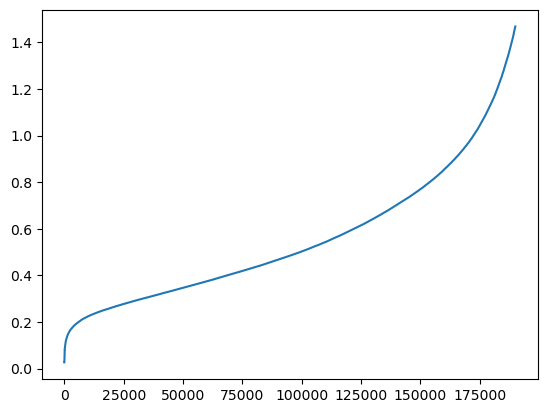

In [58]:
# Scikit-Learn met à disposition une classe NearestNeighbors qui permet de déterminer 
# les voisins les plus proches de chaque observation ainsi que les distances. 

%matplotlib inline
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:190000,1]
plt.plot(distances);

# Conclusion : prendre eps = 8 de tel sorte que au moins 95 % des 
# observations appartiennent à un groupe pour un min_sample = 5. 

# On veut au moins que 90 % des 200 000 transactions soient dans un cluster. 

# => But de ce bout de code : éviter d'avoir trop d'outliers : donne le nombre 
# de points qui sont dans un cluster. 

In [ ]:
IsFraud

In [ ]:
# Choix de eps et min_samples :

# Choix de eps : 

# Aurre possibilité pour choisir eps : 

#Eps=np.linspace(1,2.5,num=10)
#N=[]
#L=[]
#for eps in Eps:
  #clustering =  cluster.DBSCAN(eps=eps, min_samples=5)
  #clustering.fit(X)
  #labels = clustering.labels_
  #L.append(labels)
  #n=np.unique(labels)
  #N+=[len(n)]

#sns.lineplot(x=Eps,y=N)


# Nbr d'outliers : 

#for s in L:
    #d = Counter(s)
    #for i in d:
        #print(i, d[i])

In [61]:
 # Choix de min_samples : On test des eps autour de 0.8 et 1.4 avec des min_sample = 4 ou 6 ou 8. 

Eps = [0.8]
Sample = [4,6,8]
N=[]

x = []
hue = []

for sample in Sample:
  for eps in Eps:
    clustering=cluster.DBSCAN(eps, min_samples=sample, n_jobs = -1)
    clustering.fit(X)
    labels=clustering.labels_
    n=np.unique(labels)
    N+=[len(n)]

    x.append(eps) 
    hue.append(sample)

sns.lineplot(x= hue,y=N, hue = x)

# On affiche le nombre de groupes créés : 


KeyboardInterrupt: 

In [ ]:
# Choix intéressant pour eps et min_samples :  1 et 5

clustering=cluster.DBSCAN(eps=0.8, min_samples=5, n_jobs = -1)
clustering.fit(X)
len(np.unique(clustering.labels_))

# Nombre de groupes : 

In [ ]:
labels = clustering.labels_
d = Counter(labels)
d[-1]


# Nombre d'outliers pour ce choix de eps et min_sample : 
# Environ 10 %  

In [190]:
# On va faire 2 méthodes de réduction de dimension : ACP et UMAP. 

# On commence par l'ACP. 

# ACP : réduction de dimension => représenter la méthode DBSCAN (nuage de points)
# On utilise les 2 dimensions les plus représentatives du sample (dim 1 et dim 2, les dimensions 
# avec les valeurs propres les plus grandes.) 

pca = PCA()
pca.fit(df_cct)
df_cct.columns = df_cct.columns.astype("str")
df_cct_pca = pca.transform(df_cct)
df_cct_pca_df = pd.DataFrame({
    "Dim1" : df_cct_pca[:,0], 
    "Dim2" : df_cct_pca[:,1]})
df_cct_pca_df["labels"] = clustering.labels_

In [ ]:
# Faire apparaître les valeurs propres sur l'ACP.  => Interpréter / comprendre les axes + représentatifs ? 


eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig


In [ ]:
import matplotlib.pyplot as plt

eig.plot.bar(x = "Dimension", y = "% variance expliquée") # permet un diagramme en barres
plt.text(5, 100/(len(pca.explained_variance_)+1), str(np.round(100/(len(pca.explained_variance_)+1)))+"%") # ajout de texte
plt.axhline(y = (100/(len(pca.explained_variance_)+1)), linewidth = .5, color = "dimgray", linestyle = "--") # (100/(len(pca.explained_variance_)+1)) (nb dimensions)
plt.show()


In [ ]:
# Représentation de l'ACP :

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
df_cct_pca_df.plot.scatter("Dim1", "Dim2", ax = ax)

# boucle sur chaque pays
# for k in df_cct_pca_df.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    # if (abs(k[1]['Dim1']) > 5) & (abs(k[1]['Dim2']) > 5):
        # ax.annotate(k[1]["Amount"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
# Représentation de DBSCAN avec l'ACP : 
sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = df_cct_pca_df, x = "Dim1", y = "Dim2", hue = df_cct_pca_df["labels"], palette="Spectral")

In [19]:
# Affichage du cercle des corrélations pour interpréter les axes de l'ACP : 

n = df_cct.shape[0] # nb individus
p = df_cct.shape[1] # nb variables
eigval = (n-1) / n * pca.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': df_cct.columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})
coordvar

In [20]:
# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize = (10,10))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

In [21]:
    # Interprétation du cercle des corrélations : 
    # Les variables "biens" expliquées par l'ACP sont : 
    # hr-nbt/last\_30d\_av\_hr\_nbt, nb\_daily\_declines\_card, daily\_amount, last\_3d\_amt/nbt, 
    # Amount, delta\_t\_s, delta\_t\_s\_card. 
    # L'axe horizontale : les points les plus à droite représentent les transactions 
    # avec des montants élevés. A gauche inversement. 
    # L'axe verticale : en haut : féquence des transactions importantes, 
    # en bas l'inverse et transactions refusées élevés. 
    # Quand on regarde de plus près les valeurs des corrélations : on se rend compte que : 
    # Amount, delta_t_s et delta_t_s_card et nb\_daily\_declines\_card représentent à eux trois les axes. 
    # Conclusion : Axe 1 : montant, Axe 2 : fréquence et montant + declines.
    # Globalement dataset : petites fréquences et pas mal de rejets. 

In [191]:
# Si le temps : 

#!!!!!!!!!!!!!!!!!!!
# ACP en cascade :........................
#- ACP en cascade : sélectionner 10 familles de variables, faire une ACP sur chaque famille, 
# récupérer les axes, faire une 2e ACP sur toutes les ACP 
# (pour enlever le problème des variables catégorielles)
# Sparse ACP ?
#!!!!!!!!!!!!!!!!!!!

In [192]:
# On passe à la méthode UMAP : 


#!pip install umap-learn

In [11]:
# Un simple !pip install umap et import umap ne fonctionne pas... 
import umap.umap_ as umap

In [12]:
# Différence entre UMPA et ACP : 
# Bien spécifier dans le rapport : intéret de UMAP : rapidité, conserve la structure, ... mieux que t-SNE.
# UMAP preserves more of the data global structure. (compared to t-SNE) 

# UMAP : autre méthode de réduction de dimension :

reducer = umap.UMAP()
reduced_X = reducer.fit_transform(df_cct.values)

                User           Year        Amount   Credit Limit  \
count  200000.000000  200000.000000  2.000000e+05  200000.000000   
mean     1000.657580    2011.972545  1.232882e-14   15174.743755   
std       569.972184       5.080235  1.000003e+00   12138.363058   
min         0.000000    1991.000000 -5.838872e+00       0.000000   
25%       510.000000    2008.000000 -3.989315e-01    7600.000000   
50%      1006.000000    2013.000000 -1.651841e-01   13254.000000   
75%      1478.000000    2016.000000  2.269221e-01   20289.000000   
max      1999.000000    2020.000000  5.266152e+01  151223.000000   

       Year PIN last Changed     delta_t_s  delta_t_s_card  amt/daily_income  \
count          200000.000000  2.000000e+05    2.000000e+05      2.000000e+05   
mean             2011.220795 -3.001460e-17   -1.301174e-17     -5.445459e-16   
std                 3.061815  1.000003e+00    1.000003e+00      1.000003e+00   
min              2002.000000 -3.641605e-01   -2.774233e-01     -3.6

In [194]:
reduced_df = pd.DataFrame(reduced_X, columns = ["A1", "A2"])
reduced_df["Label"] = clustering.labels_

In [197]:
# Représentation de DBSCAN avec UMAP : 

sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = reduced_df, x = "A1", y = "A2", hue = "Label", palette="Spectral")

array([[1.347e+03, 2.012e+03, 1.200e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [8.420e+02, 2.016e+03, 1.100e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [6.460e+02, 2.019e+03, 6.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [5.100e+02, 2.006e+03, 3.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.102e+03, 2.018e+03, 1.000e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [4.450e+02, 2.006e+03, 2.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

In [27]:
# Interprétation des résultats : On commence par DBSCAN x UMAP : 

# 1. Trouver les points correspondant à des frands : 

# Idée : essayer d'identifier les types de transaction reliés à chaque clusters. 

# Quelle valeur correspond à une transaction en ligne ? 

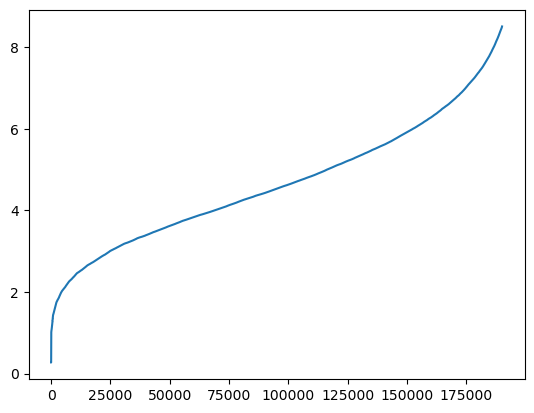

In [198]:
val = df_cct["Online Transaction"].unique()[1]

reduced_dfbis = pd.concat([reduced_df, df_cct["Online Transaction"]], axis = 1)

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

for k in reduced_dfbis.iterrows():
    if (k[1]['Online Transaction'] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()


# Il y en a un peu partout : Tranches : jaune orange 


In [29]:
# Essayons pour les autres types de transaction : 

reduced_dfbis = pd.concat([reduced_df, df_cct["Chip Transaction"]], axis = 1)

val = df_cct["Chip Transaction"].unique()[1]

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

for k in reduced_dfbis.iterrows():
    if (k[1]["Chip Transaction"] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
reduced_dfbis = pd.concat([reduced_df, df_cct["Swipe Transaction"]], axis = 1)

val = df_cct["Swipe Transaction"].unique()[1]

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")


for k in reduced_dfbis.iterrows():
    if (k[1]["Swipe Transaction"] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
# Trouver les outliers : 

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

for k in reduced_dfbis.iterrows():
    if (k[1]["Label"] == -1) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()


In [ ]:
# Trouver les frauds : 
reduced_dfbis = pd.concat([reduced_df, IsFraud], axis = 1)

val = IsFraud.unique()[1]

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

for k in reduced_dfbis.iterrows():
    if (k[1]["Is Fraud?"] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 15)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
# A faire : 

# 1. Interpréter UMAP => faire UMAP uniquement sur 2 3 variables => essayer d'interpréter les axes. Le faire plusieurs fois. 

# 2. Pour l'ACP (pas passer trop de temps dessus) Regarder matrice de corrélation, les variables corrélé représentent souvent un axe, un paquet. 

# 1. Interpréter UMAP => faire UMAP uniquement sur 2 3 variables => 
# essayer d'interpréter les axes. Le faire plusieurs fois. 


df_sub = df_cct[['amt/daily_income', 'daily_amount', 'last_3d_amt/nbt', 'Amount']] 



In [ ]:
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# DBSCAN

X = df_sub.values
X.astype(np.float64)

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:190000,1]
plt.plot(distances);

In [ ]:


clustering=cluster.DBSCAN(eps=0.06, min_samples=5, n_jobs = -1)
clustering.fit(X)
len(np.unique(clustering.labels_))

# Nbr de clusters : 

In [ ]:
# UMAP

reducer = umap.UMAP()
reduced_X = reducer.fit_transform(df_sub.values)

reduced_df = pd.DataFrame(reduced_X, columns = ["A1", "A2"])
reduced_df["Label"] = clustering.labels_

# Représentation de DBSCAN avec UMAP : 

sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = reduced_df, x = "A1", y = "A2", hue = "Label", palette="Spectral")


In [ ]:
# Prendre une variable montant et une varaible fréquence de transaction : 

df_sub1 = df_cct[['Amount', 'delta_t_s']] 
df_sub1.describe()

In [ ]:
# DBSCAN

X = df_sub1.values
X.astype(np.float64)

In [ ]:
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:190000,1]
plt.plot(distances);

In [ ]:


clustering=cluster.DBSCAN(eps=0.005, min_samples=5, n_jobs = -1)
clustering.fit(X)


len(np.unique(clustering.labels_))


# Nbr de clusters : 

In [27]:
len(df_cct)

200000

In [28]:
df_cct.columns

Index(['Amount', 'delta_t_s', 'delta_t_s_card', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt',
       'Is Fraud?', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'Merchant State_CA', 'Merchant State_FL',
       'Merchant State_IL', 'Merchant State_NC', 'Merchant State_NY',
       'Merchant State_OH', 'Merchant State_PA', 'Merchant State_TX',
       'Merchant State_None', 'Merchant State_infrequent_sklearn',
       'Merchant City_Brooklyn', 'Merchant City_Chicago',
       'Merchant City_Dallas', 'Merchant City_Houston',
       'Merchant City_Indianapolis', 'Merchant City_Los Angeles',
       'Merchant City_Miami', 'Merchant City_ONLINE', 'Merchant City_Orlando',
       'Merchant City_infrequent_sklearn', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

<AxesSubplot: xlabel='A1', ylabel='A2'>

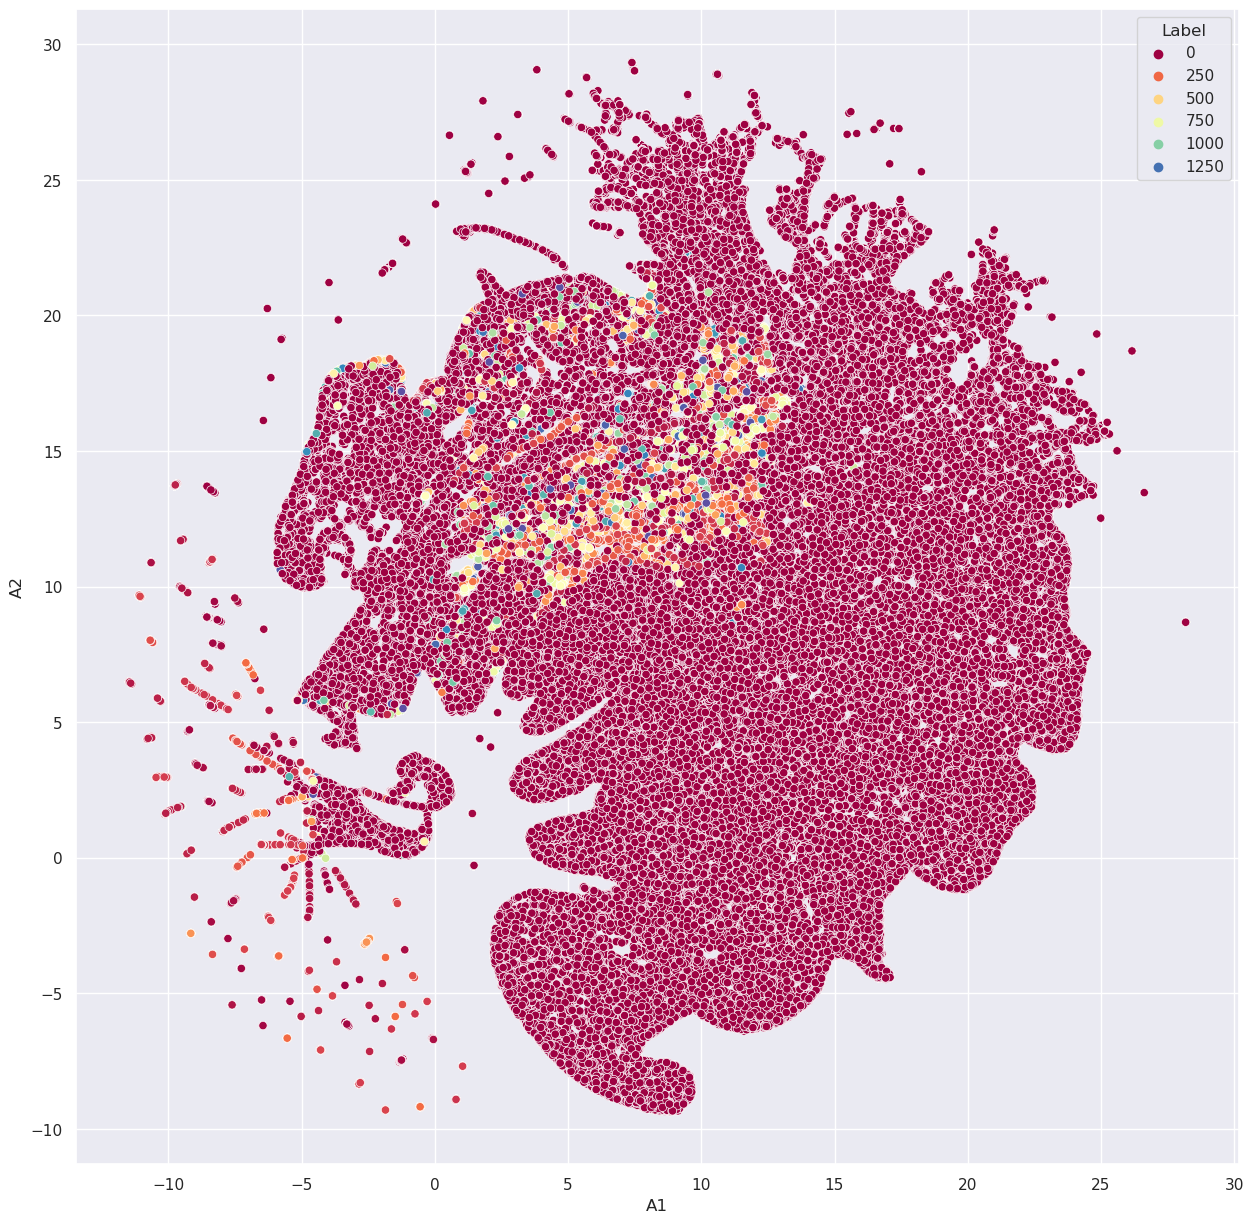

In [27]:
# UMAP

reducer = umap.UMAP()
reduced_X = reducer.fit_transform(df_sub1.values)

reduced_df = pd.DataFrame(reduced_X, columns = ["A1", "A2"])
reduced_df["Label"] = clustering.labels_

# Représentation de DBSCAN avec UMAP : 

sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = reduced_df, x = "A1", y = "A2", hue = "Label", palette="Spectral")

In [34]:
# Prendre une variable montant et une varaible fréquence de transaction : 

df_sub2 = df_cct[['Amount', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'delta_t_s' ]] 
df_sub2.describe()

Amount  Chip Transaction  Online Transaction  Swipe Transaction  \
count  2.000000e+05     200000.000000       200000.000000      200000.000000   
mean  -4.142464e-17          0.253440            0.136035           0.610525   
std    1.000003e+00          0.434982            0.342827           0.487632   
min   -5.887323e+00          0.000000            0.000000           0.000000   
25%   -4.039523e-01          0.000000            0.000000           0.000000   
50%   -1.684048e-01          0.000000            0.000000           1.000000   
75%    2.306965e-01          1.000000            0.000000           1.000000   
max    6.079847e+01          1.000000            1.000000           1.000000   

          delta_t_s  
count  2.000000e+05  
mean  -3.197442e-18  
std    1.000003e+00  
min   -3.062027e-01  
25%   -2.778993e-01  
50%   -1.633995e-01  
75%    1.530831e-01  
max    3.075774e+02

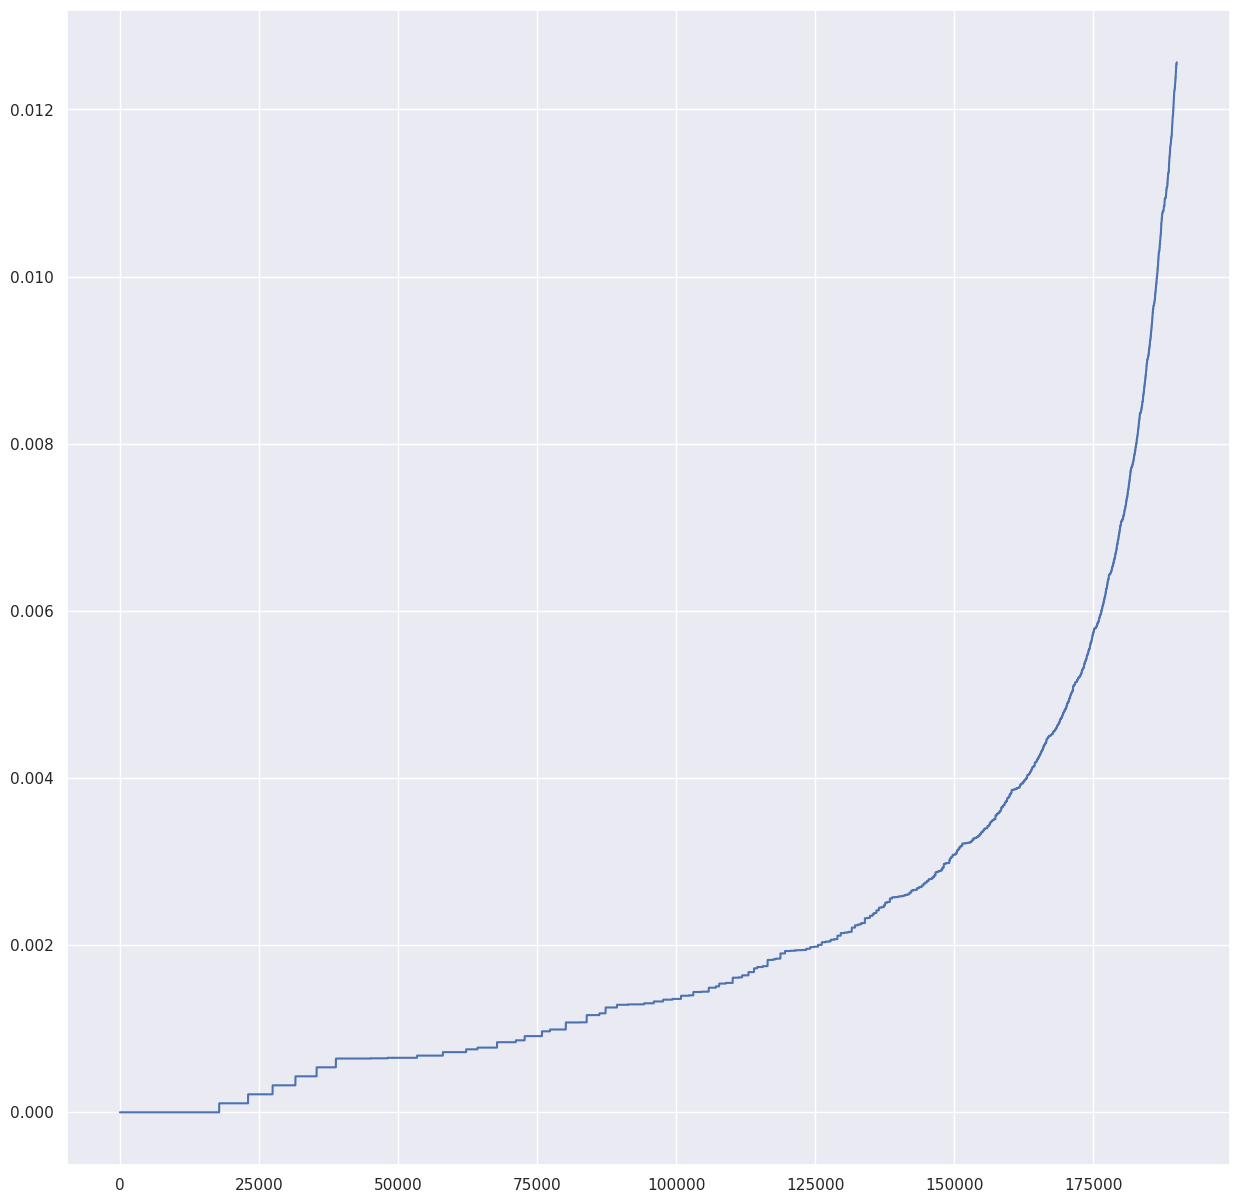

In [35]:

# DBSCAN

X = df_sub2.values
X.astype(np.float64)

%matplotlib inline
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:190000,1]
plt.plot(distances);

In [36]:
clustering=cluster.DBSCAN(eps=0.012, min_samples=5, n_jobs = -1)
clustering.fit(X)
len(np.unique(clustering.labels_))

809

<AxesSubplot: xlabel='A1', ylabel='A2'>

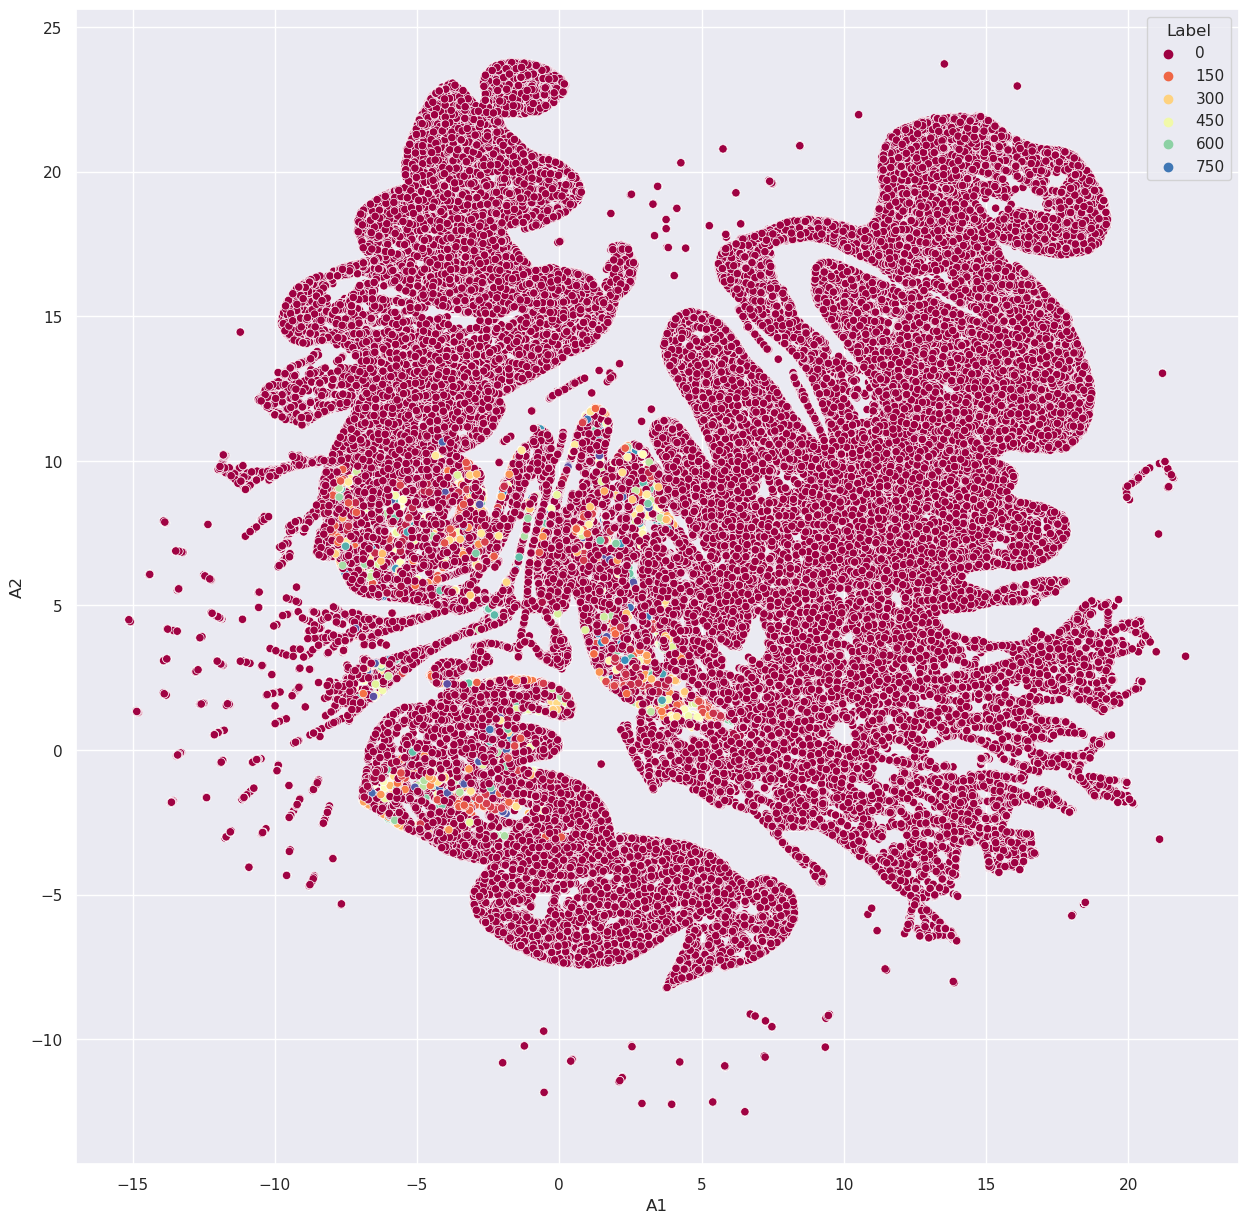

In [37]:
# UMAP

reducer = umap.UMAP()
reduced_X = reducer.fit_transform(df_sub2.values)

reduced_df = pd.DataFrame(reduced_X, columns = ["A1", "A2"])
reduced_df["Label"] = clustering.labels_

# Représentation de DBSCAN avec UMAP : 

sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = reduced_df, x = "A1", y = "A2", hue = "Label", palette="Spectral")

In [38]:
# C'est très long à générer => 1 h environ...
# Résultats pas très concluant... 

a


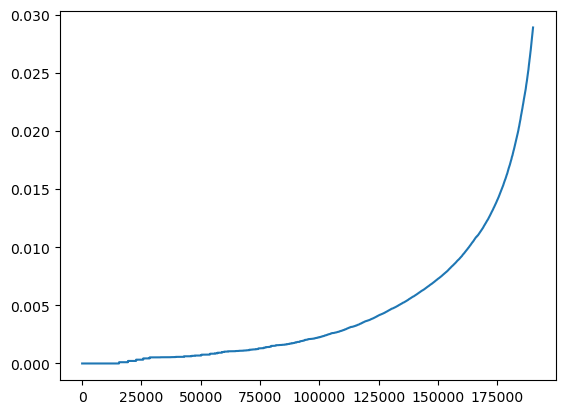

In [19]:
df_sub3 = df_cct[['Amount', 'delta_t_s', "delta_t_s_card", 'nb_daily_declines_card']] 
df_sub3.describe()



# DBSCAN

X = df_sub3.values
X.astype(np.float64)

%matplotlib inline
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:190000,1]
plt.plot(distances);


In [20]:
clustering=cluster.DBSCAN(eps=0.025, min_samples=5, n_jobs = -1)
clustering.fit(X)
len(np.unique(clustering.labels_))

565

<AxesSubplot: xlabel='A1', ylabel='A2'>

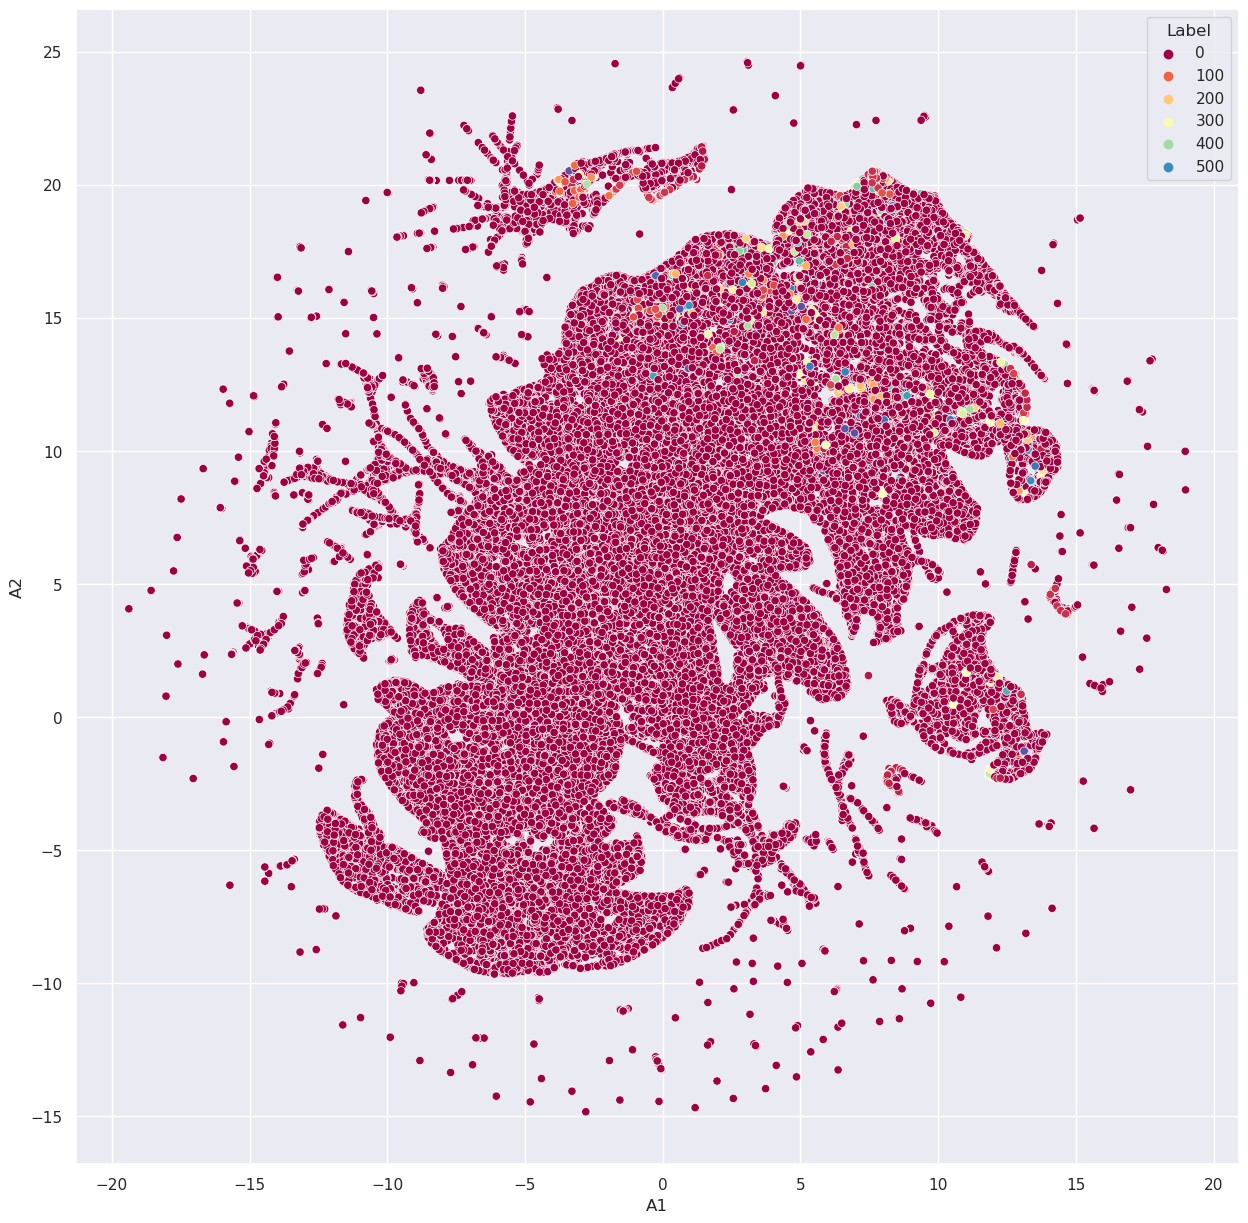

In [21]:
# UMAP

reducer = umap.UMAP()
reduced_X = reducer.fit_transform(df_sub3.values)

reduced_df = pd.DataFrame(reduced_X, columns = ["A1", "A2"])
reduced_df["Label"] = clustering.labels_

# Représentation de DBSCAN avec UMAP : 

sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = reduced_df, x = "A1", y = "A2", hue = "Label", palette="Spectral")

In [ ]:
####

In [ ]:
df_cct_cluster =  pd.concat([df_cct, pd.DataFrame( clustering.labels_ ,columns = ["Label_Cluster"], index = df_cct.index)], axis = 1)



In [ ]:
df_cct_cluster.head()

In [ ]:
df_cct_cluster["Label_Cluster"].unique()

In [ ]:
count = df_cct_cluster.groupby(['Label_Cluster']).count().sort_index(ascending = False)["Amount"]
df_cct_mean = df_cct_cluster.groupby(['Label_Cluster']).mean().sort_index(ascending = False)
df_cct_std = df_cct_cluster.groupby(['Label_Cluster']).std().sort_index(ascending = False)
df_cct_std.columns = df_cct_std.columns + str("var")

In [ ]:
df_cct_std.columns = df_cct_std.columns + str("var")
reducer = umap.UMAP()
reduced_X = reducer.fit_transform(df_cct_mean.values)
reduced_df = pd.DataFrame(reduced_X, columns = ["A1", "A2"])
reduced_df["Count"] = count.values
reduced_df["Label"] = df_cct_mean.index.values
reduced_df["Amount_mean"] = df_cct_mean["Amount"]


In [ ]:
from matplotlib import pyplot as plt

# Scatter plot (plot à point avec palette de couleur par défaut Viridis()

# scatter(x,y,c=color, s=taille)

plt.scatter('A1', 'A2', c='Label', s='Count', data=reduced_df,  cmap='jet')

plt.xlabel('A1')

plt.ylabel('A2')

cbar= plt.colorbar()

plt.show()

In [ ]:
import plotly.express as px

fig = px.scatter(reduced_df, x="A1", y="A2", color="Label",
                 size='Count', size_max=200, hover_name = "Amount_mean", height = 800, width = 800)
fig.show()




